* Importar librerias

In [1]:
import pandas as pd
from apyori import apriori
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
import matplotlib
import squarify
import networkx as nx
from wordcloud import WordCloud
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

* Cargamos los datos con la función read_csv()

In [2]:
data = pd.read_csv('Groceries_dataset.csv')

* Función head():
* Muestra por defecto las primeras 5 filas.
* Puede mostrar los elementos que querramos si pasamos un número entero a la funcion.

In [3]:
data.head()

Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk

* info(): proporciona informacion sobre nuestra base de datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
Member_number      38765 non-null int64
Date               38765 non-null object
itemDescription    38765 non-null object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


* Visualizar nombre de comlumnas

In [5]:
data.columns.values

array(['Member_number', 'Date', 'itemDescription'], dtype=object)

In [6]:
data.shape

(38765, 3)

### Palabras clave de los productos mas vendidos 

* Utilizamos la libreria plotly para vizualizar las siguientes graficas

(-0.5, 1199.5, 999.5, -0.5)

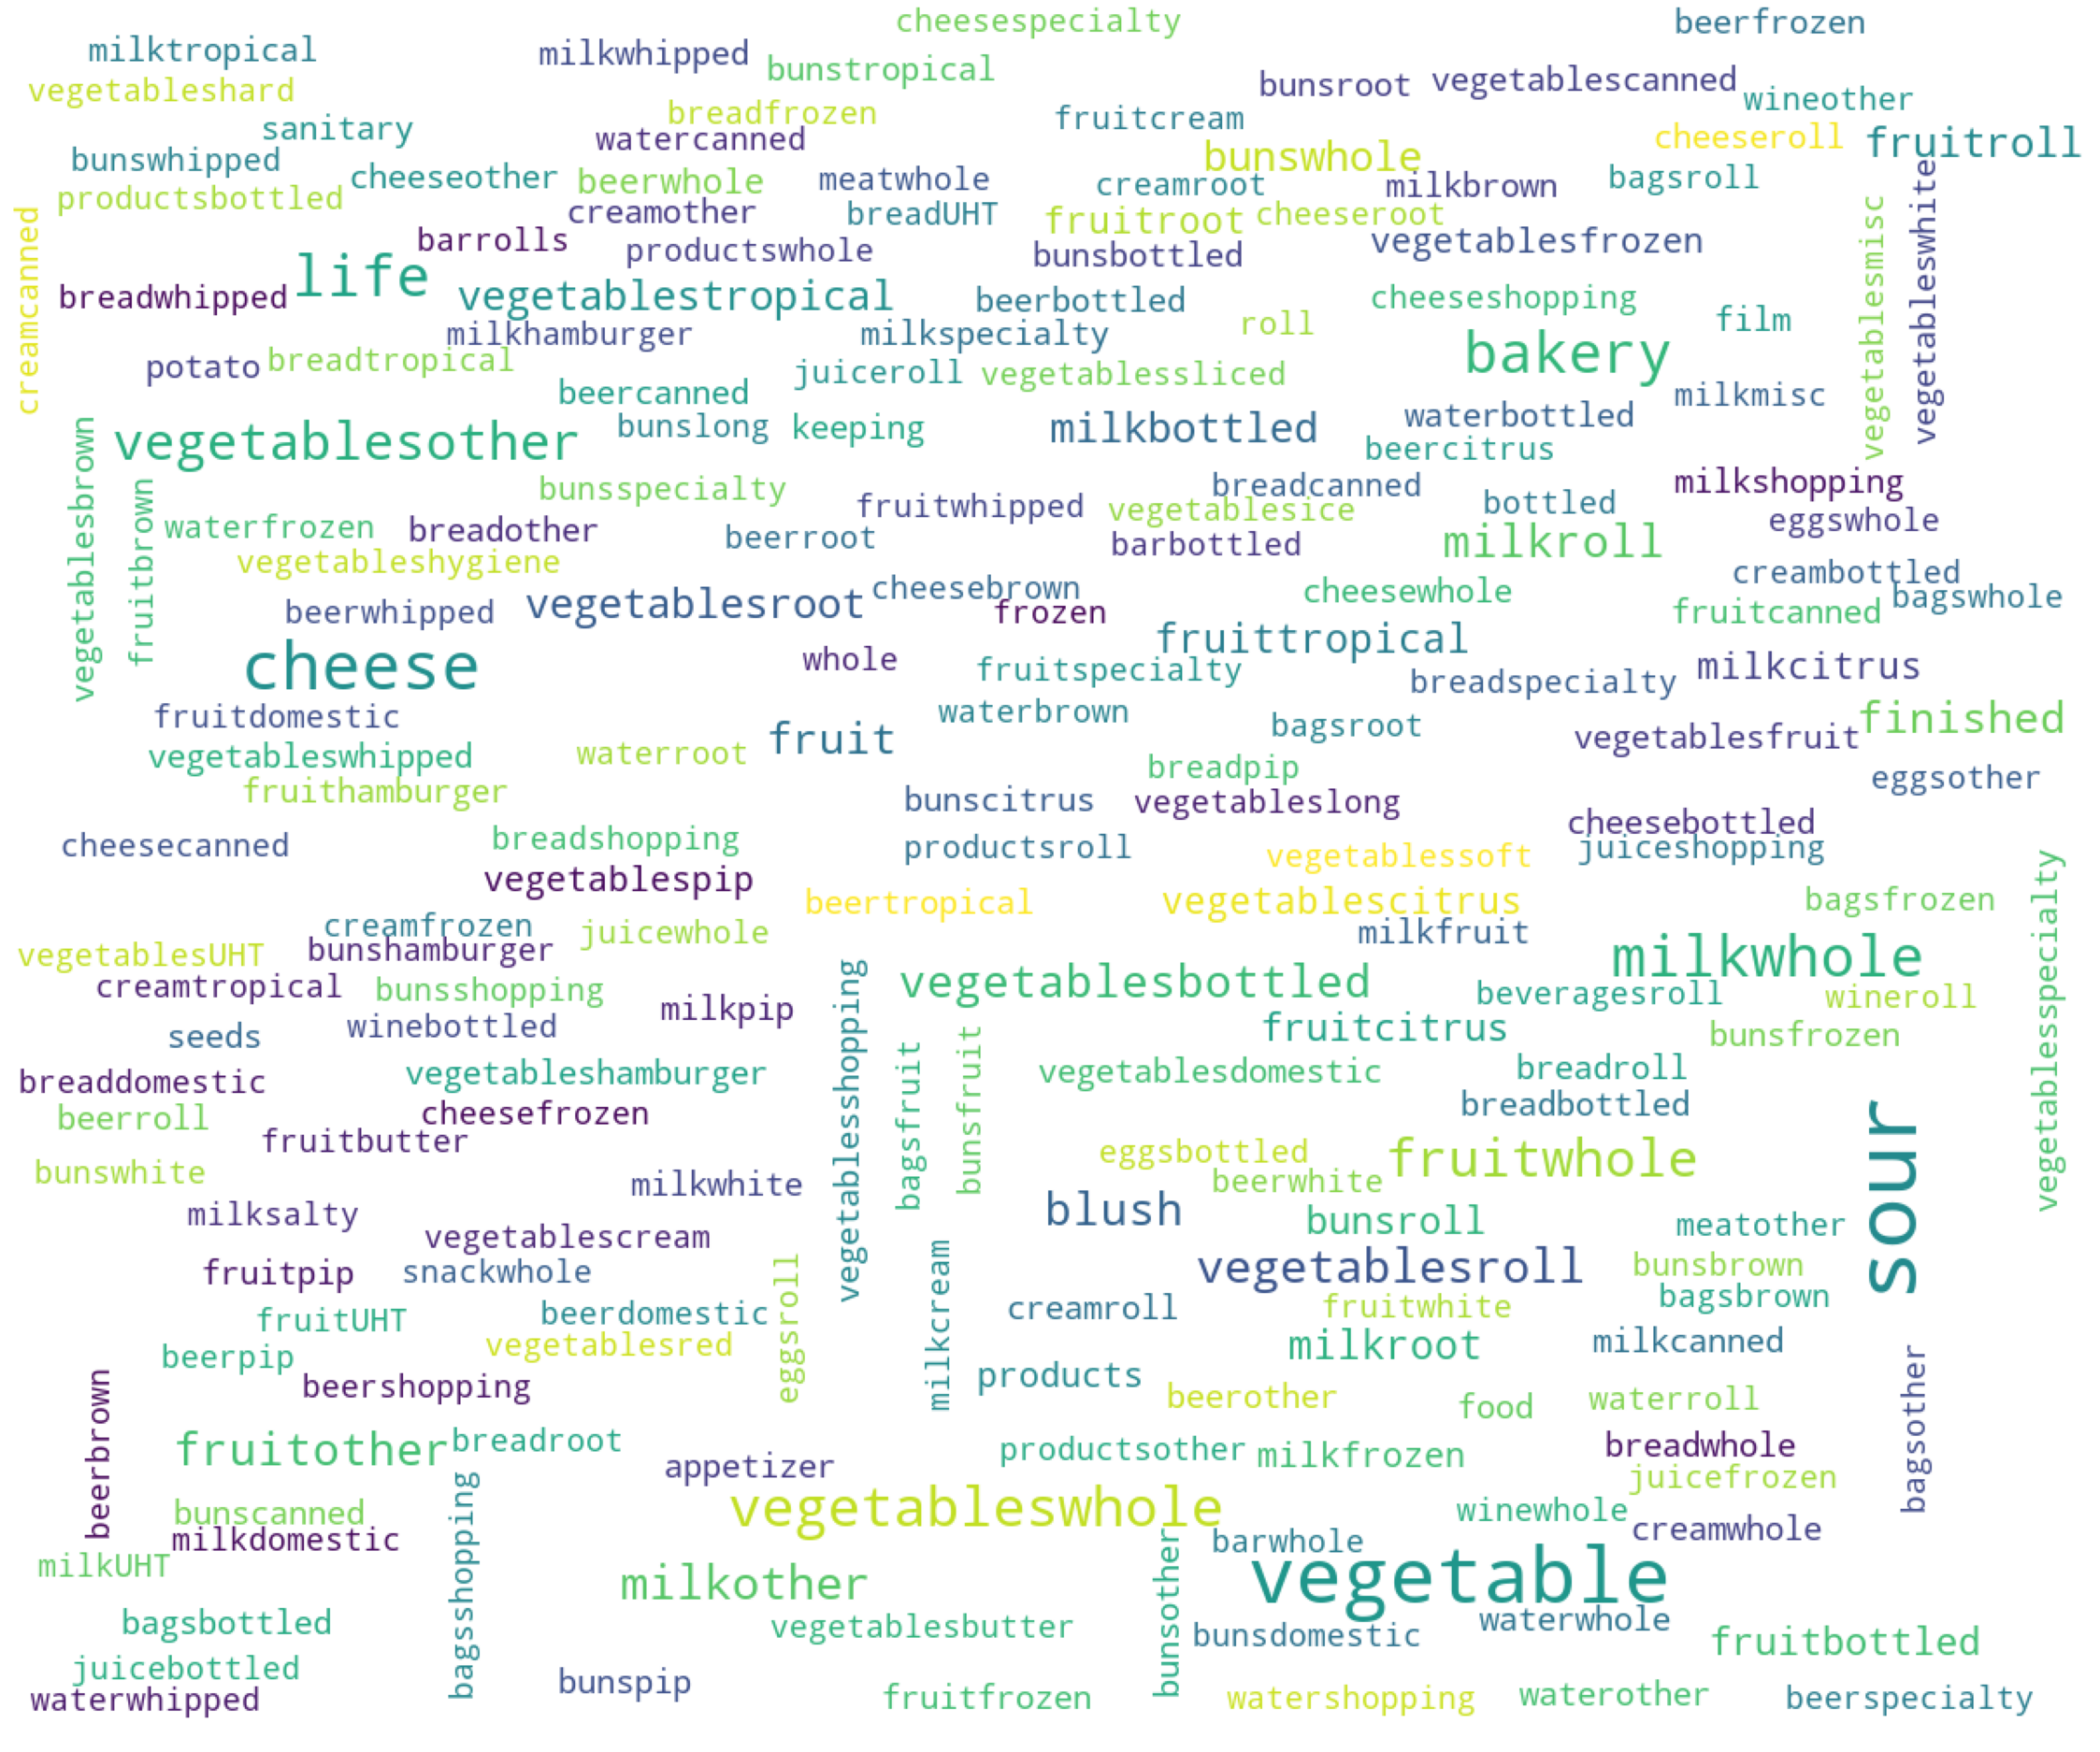

In [7]:
plt.subplots(figsize=(40,40))
wordcloud = WordCloud(background_color = 'white',
                          width=1200, height=1000,max_font_size = 50,
                      collocations=False).generate("".join(data['itemDescription']))

plt.imshow(wordcloud)
plt.axis('off')

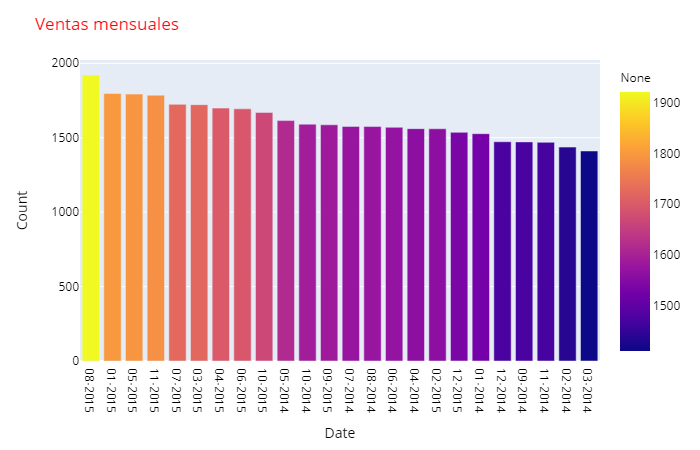

In [8]:
data["Year"] = data["Date"].str.split("-").str[-1]
data["Months_Year"] = data["Date"].str.split("-").str[1] + "-" + data["Date"].str.split("-").str[-1] 
fig = px.bar(data["Months_Year"].value_counts(ascending=False), orientation="v", 
             color=data["Months_Year"].value_counts(ascending=False), 
             color_continuous_scale=px.colors.sequential.Plasma, 
             log_x=False, labels={'value':'Count', 'index':'Date','color':'None'})
fig.update_layout(
    font_color="black",
    title_font_color="red",
    legend_title_font_color="green",
    title_text="Ventas mensuales"
)

fig.show(renderer="png")
#fig.show()

* Items totales

In [9]:
products  = data['itemDescription'].unique()

In [10]:
len(products)

167

* Proceso para crear variables dummie:

In [11]:
def createDummies(df,var_name):
    dummy = pd.get_dummies(data[var_name] )
    df = df.drop(var_name, axis = 1)
    df = pd.concat([df,dummy], axis = 1)
    return df

In [12]:
data.head()

Member_number        Date   itemDescription  Year Months_Year
0           1808  21-07-2015    tropical fruit  2015     07-2015
1           2552  05-01-2015        whole milk  2015     01-2015
2           2300  19-09-2015         pip fruit  2015     09-2015
3           1187  12-12-2015  other vegetables  2015     12-2015
4           3037  01-02-2015        whole milk  2015     02-2015

* Variables dummie

* Generamos variables dummie para poder utilizar el algoritmo apriori

In [13]:
data3 = createDummies(data,"itemDescription")

* Quitamos las columnas "Member_number","Date"
* Reseteamos el index

In [14]:
reportes = data3.groupby(["Member_number","Date"])[products[:]].sum()
reportes = reportes.reset_index()[products]

* Esta función realiza un cambio de numeros a palabras
* Solo si encuentra un 1 lo cambia por el nombre de la columna

In [15]:
def get_product_names(x):
    for product in products:
        if x[product] != 0:
            x[product] = product
    return x

reportes = reportes.apply(get_product_names, axis=1)

In [16]:
x = reportes.values
x = [sub[~(sub == 0)].tolist() for sub in x if sub[sub != 0].tolist()]
transactions = x

* Utilizamos algoritmo de reglas de asociacion 
* Covertimos nuestras reglas a formato lista

In [17]:
association_rules = apriori(transactions,min_support=0.000333, min_confidance=0.4, min_lift=3.2, min_length=2, target="rules")

association_results = list(association_rules)


* Creamos un nuevo dataFrame que contendra nuestras reglas de asociación.

In [18]:
reglas = pd.DataFrame(columns = ['from','to','confidence','support','lift'])

* Rellenamos el dataFrame

In [19]:
i = 0
for item in association_results:

    pair = item[0] 
    items = [x for x in pair]
    reglas.loc[i]=[items[0] , items[1] , str(item[2][0][2]) , str(item[1]), str(item[2][0][3])]
    i+=1

* Pintamos un grafo con nuestras reglas de asociación

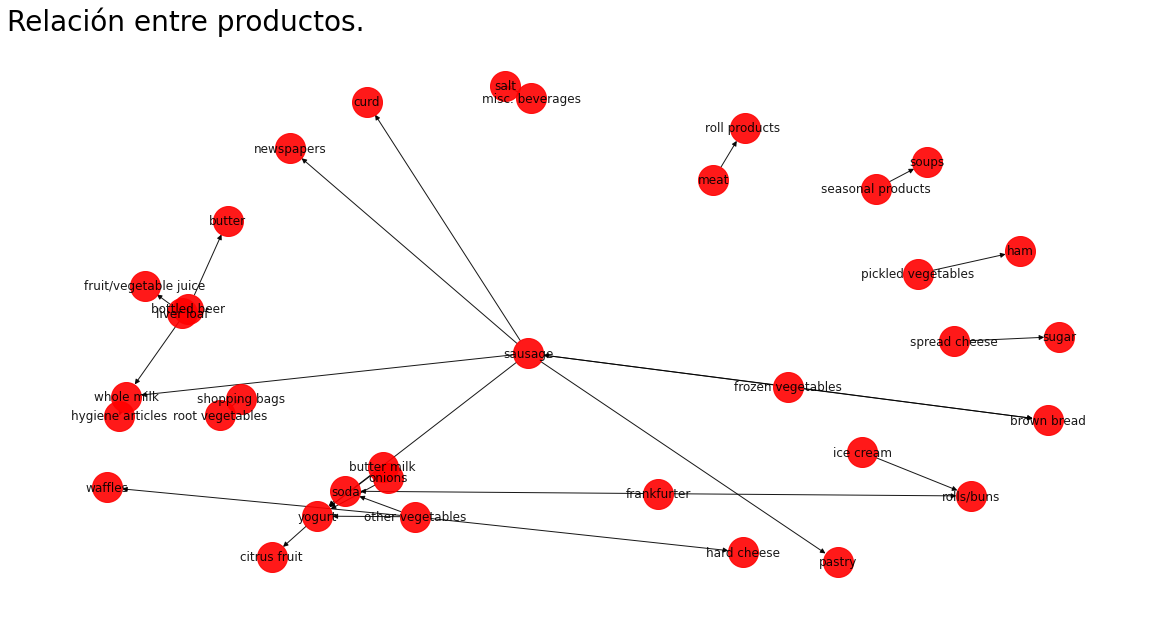

In [20]:
G=nx.from_pandas_edgelist(reglas, 'from', 'to', create_using=nx.DiGraph() )
       
nx.spring_layout(G,k=0.5,iterations=len(reglas))

plt.figure(3,figsize=(16,8))

nx.draw(G, with_labels=True, node_size=900, alpha=0.9,
        arrows=True,font_size=12,node_color = 'red',
       )
plt.title("Relación entre productos.",fontsize=28,loc='left')

plt.savefig("Graph.png", format="PNG")
plt.show(block=False)

* Generamos un archivo csv con nuestras reglas de asociación

In [21]:
reglas.to_csv("AsociacionReglas.csv")

* Comprobamos que exista el archivo

In [22]:
h = pd.read_csv("AsociacionReglas.csv")

In [23]:
i = h[(h['support']>0.000400)]
i = i[i['confidence']>.20]
i

Unnamed: 0        from                to  confidence   support      lift
9            9     sausage       brown bread    0.222222  0.000401  4.736626
12          12  whole milk  hygiene articles    0.545455  0.000401  3.453930
13          13        soda            yogurt    0.400000  0.000401  4.657743
14          14      yogurt      citrus fruit    0.300000  0.000401  3.493307
20          20     sausage            yogurt    0.205882  0.000468  3.411537

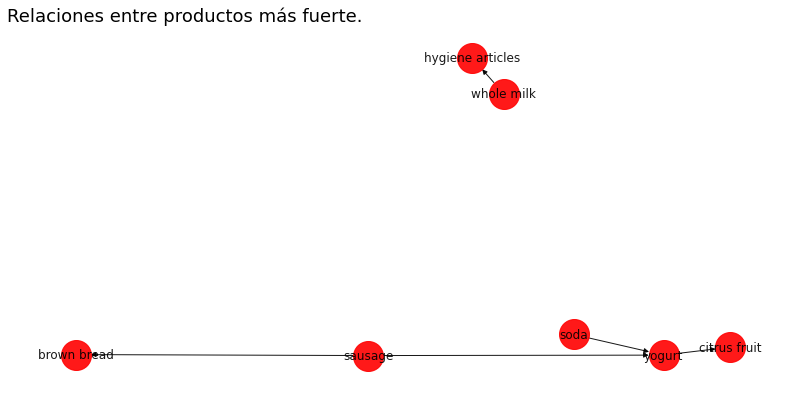

In [24]:
G=nx.from_pandas_edgelist(i, 'from', 'to', create_using=nx.DiGraph() )
       
nx.spring_layout(G,k=0.5,iterations=len(reglas))

plt.figure(3,figsize=(11,5))

nx.draw(G, with_labels=True, node_size=900, alpha=0.9,
        arrows=True,font_size=12,node_color = 'red',
       )
plt.title("Relaciones entre productos más fuerte.",fontsize=18,loc='left')

plt.savefig("Graph.png", format="PNG")
plt.show(block=False)

## Sistema de recomendacion 

In [25]:
top = data['itemDescription'].value_counts()
df = top.to_frame()
df['item'] = df.index
df['id_producto'] = range(0, len(top))
df['index'] = range(0, len(top))
df["ventas"]=range(0, len(top))

df.set_index('index', inplace=True)
df = df.rename(columns={'item':'itemDescription',
                                   'itemDescription':'id_usuario'})
longitud = 0
for i in df['itemDescription']:
    df.loc[longitud,"ventas"]=len(reportes[reportes[i]==i])
    longitud+=1
df.head()

id_usuario   itemDescription  id_producto  ventas
index                                                   
0            2502        whole milk            0    2363
1            1898  other vegetables            1    1827
2            1716        rolls/buns            2    1646
3            1514              soda            3    1453
4            1334            yogurt            4    1285

In [26]:
df.head()

id_usuario   itemDescription  id_producto  ventas
index                                                   
0            2502        whole milk            0    2363
1            1898  other vegetables            1    1827
2            1716        rolls/buns            2    1646
3            1514              soda            3    1453
4            1334            yogurt            4    1285

In [27]:
df.tail(10)

id_usuario        itemDescription  id_producto  ventas
index                                                        
157             8                 whisky          157       8
158             6         salad dressing          158       6
159             5        rubbing alcohol          159       5
160             5         toilet cleaner          160       5
161             5        make up remover          161       5
162             5         frozen chicken          162       5
163             4                   bags          163       4
164             3         baby cosmetics          164       3
165             1  preservation products          165       1
166             1        kitchen utensil          166       1

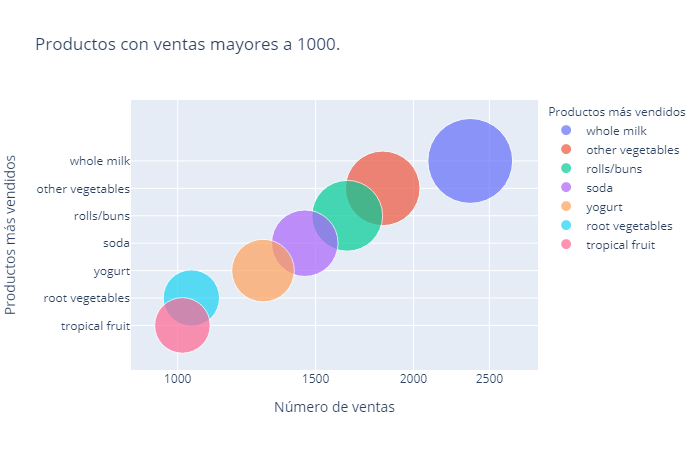

In [28]:
fig = px.scatter(df.query("ventas > 1000"), x="ventas", y="itemDescription",
         size="ventas", color="itemDescription",
                 hover_name="itemDescription", log_x=True, size_max=60,
            labels={'itemDescription':'Productos más vendidos','ventas':'Número de ventas'}
                , title="Productos con ventas mayores a 1000.")
fig.write_image("ventasMayor1000.png")
fig.show(renderer="png")
#fig.show()

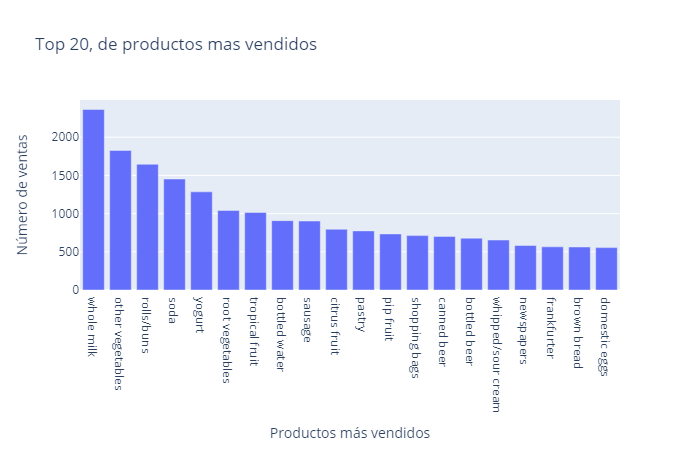

In [29]:
fig = px.bar(df[0:20],x='itemDescription', y='ventas', title="Top 20, de productos mas vendidos",
            labels={'itemDescription':'Productos más vendidos','ventas':'Número de ventas'})
fig.show(renderer="png")
#fig.show()

In [30]:
lon = len(df)
for i in range(lon):
    if (i == 0 ):
        df.loc[0,'ventas']=5
    else:
        df.loc[i,'ventas']=math.ceil((df.loc[i,'ventas']*df.loc[0,'ventas'])/2363)
df.head()

id_usuario   itemDescription  id_producto  ventas
index                                                   
0            2502        whole milk            0       5
1            1898  other vegetables            1       4
2            1716        rolls/buns            2       4
3            1514              soda            3       4
4            1334            yogurt            4       3

### Peliculas mas vistas se encuentra en rango de 0 a 250
* Incluir productos poco comprados aleatoriamente al sistema

(array([121.,  21.,  14.,   4.,   2.,   1.,   2.,   1.,   0.,   1.]),
 array([1.0000e+00, 2.5110e+02, 5.0120e+02, 7.5130e+02, 1.0014e+03,
        1.2515e+03, 1.5016e+03, 1.7517e+03, 2.0018e+03, 2.2519e+03,
        2.5020e+03]),
 <a list of 10 Patch objects>)

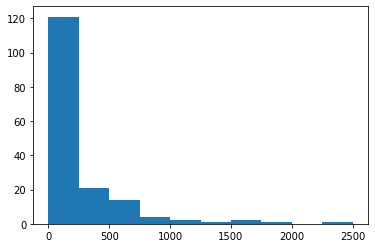

In [31]:
plt.hist(data.groupby(["itemDescription"])["itemDescription"].count())

In [32]:
n_users = data.Member_number.unique().shape[0]
n_users

3898

In [33]:
n_items = data.itemDescription.unique().shape[0]
n_items

167

### Representación en forma matricial

In [34]:
ratings = np.zeros((n_users,n_items))

In [35]:
for row in df.itertuples():
    ratings[row[1],row[3]] = row[4]
    

In [36]:
ratings.shape

(3898, 167)

In [37]:
spar = float(len(ratings.nonzero()[0]))
spar /= ratings.shape[0]*ratings.shape[1]
spar *= 100
print("Coeficiente de sparseidad: {:4.2f}%".format(spar))

Coeficiente de sparseidad: 0.03%


### Crear conjunto de entrenamiento

In [38]:
ra_training , ra_test = train_test_split(ratings,test_size=0.3,random_state=42)

In [39]:
ra_training.shape

(2728, 167)

In [40]:
ra_test.shape

(1170, 167)

In [41]:
n_items = ra_training.shape[1]
n_items

167

In [42]:
vecinos = NearestNeighbors(n_items, 'cosine')

In [43]:
vecinos.fit(ra_training.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=167, p=2,
                 radius='cosine')

In [44]:
top_k_distance, top_k_items = vecinos.kneighbors(ra_training.T, return_distance=True)

In [45]:
top_k_items

array([[  0, 129,  67, ...,   4,   1,   2],
       [  1,  51, 128, ...,   4,   2,   0],
       [  2,  51, 128, ...,   4,   1,   0],
       ...,
       [164,  51, 128, ...,   2,   1,   0],
       [166, 165, 128, ...,   2,   1,   0],
       [166, 165, 128, ...,   2,   1,   0]], dtype=int64)

In [46]:
ko = pd.DataFrame(data=top_k_items)

In [47]:
for i in range(0,len(ko)):
    for j in range(0,len(ko)):
        ko[j][i] =(df[df['id_producto']==ko[j][i]]['itemDescription']).to_string().replace('index\n'+str(ko[j][i]), '').strip()

C:\Users\rodot\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rodot\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
ko = ko.drop_duplicates()

In [49]:
reco = pd.DataFrame(columns = ['product','valor','col','porcentaje'])
lon = 11
ko['index'] = range(0, len(ko))
ko.set_index('index', inplace=True)
m = 1
for i in range(1,11):
    for j in range(0,82):
        l = len(ko[ko[i] == ko[i][j]])
       # print('Longitud de '+ko[i][j]+ ' es '+str(l)+', Columna: '+str(i)+', Porcentaje: '+str(round((l/82)*100))+'%')
        reco.loc[m]=[ko[i][j] , l , i , ((l/82)*100)]
        m+=1
        l = 0

In [50]:
reco = reco.drop_duplicates()

In [51]:
reco['index'] = range(0, len(reco))
reco.set_index('index', inplace=True)

In [52]:
recomendaciones = pd.DataFrame(columns = ['columna','producto','porcentaje'])
for i in range(1,11):
    l = reco[(reco['col'] == i) ]
    l=l.sort_values('porcentaje',ascending=False)
    l['index'] = range(0, len(l))
    l.set_index('index', inplace=True)
    recomendaciones.loc[i]=[str(l['col'][0]) , l['product'][0] , round(l['porcentaje'][0]) ]
    print('Col: '+str(l['col'][0])+', Producto: '+l['product'][0]+', Porcentaje: '+str(round(l['porcentaje'][0]))+'%')

Col: 1, Producto: grapes, Porcentaje: 67.0%
Col: 2, Producto: fish, Porcentaje: 40.0%
Col: 3, Producto: specialty fat, Porcentaje: 44.0%
Col: 4, Producto: pickled vegetables, Porcentaje: 44.0%
Col: 5, Producto: dishes, Porcentaje: 44.0%
Col: 6, Producto: soft cheese, Porcentaje: 44.0%
Col: 7, Producto: processed cheese, Porcentaje: 44.0%
Col: 8, Producto: red/blush wine, Porcentaje: 44.0%
Col: 9, Producto: cat food, Porcentaje: 28.0%
Col: 10, Producto: white wine, Porcentaje: 35.0%


In [53]:
recomendaciones

columna            producto  porcentaje
1        1              grapes        67.0
2        2                fish        40.0
3        3       specialty fat        44.0
4        4  pickled vegetables        44.0
5        5              dishes        44.0
6        6         soft cheese        44.0
7        7    processed cheese        44.0
8        8      red/blush wine        44.0
9        9            cat food        28.0
10      10          white wine        35.0

In [54]:
fig = px.scatter(recomendaciones.query("porcentaje > 10"), x="porcentaje", y="producto",
         size="porcentaje", color="producto",
                 hover_name="producto", log_x=True, size_max=60,
            labels={'producto':'Productos con más recomendaciones','porcentaje':'Porcentajes'}
                , title="Productos más recomendados.")
#fig.write_image("ventasMayor1000.png")
#fig.show(renderer="png")
fig.show()